In [154]:
import matplotlib.pyplot as plt                 # For normal plotting
from mpl_toolkits.mplot3d import proj3d         # For 3D plotting
import numpy as np                              # For maths
from scipy import ndimage                       # For image rotations
from scipy import optimize                      # For function minimization
import astra                                    # For tomography framework
import copy                                     # For deep copying arrays

import multi_axis                               # My custom functions

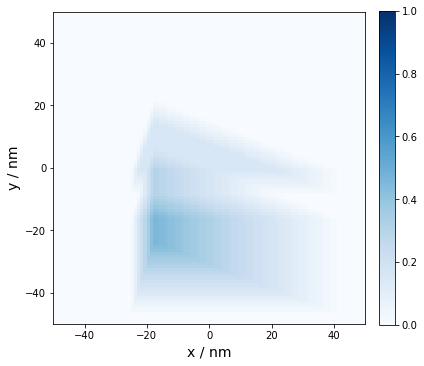

In [146]:
# Generate phantom
#X,Y,Z,P = multi_axis.generate_tri_pris()

# View in 2D
#multi_axis.plot_2d(X,Y,Z,P)

# Rotate 90 about +x and view again
Pr = multi_axis.rotate_bulk(P,50,0,0)
multi_axis.plot_2d(X,Y,Z,Pr)

In [179]:
# Create tilt series about x
ax,ay,az = 0,0,0

P_projs = []
vectors = []
thetas = []
for ay in np.linspace(-90,90,60):
    vector = multi_axis.get_astravec(ax,ay,az)
    #vector[0:3] = np.array(multi_axis.rotation_matrix(ax,ay,az)).dot([0,0,1])
    thetas.append(ax*np.pi/180)
    vectors.append(vector)
    P_rot = multi_axis.rotate_bulk(P,ax,ay,az)
    P_rot_proj =np.flipud(np.mean(P_rot,axis=2).T)
    P_projs.append(P_rot_proj)
    
raw_data = P_projs
np.shape(raw_data)

(60, 100, 100)

In [200]:
# Create tilt series about x and y
ax,ay,az = 0,0,0

P_projs = []
vectors = []
for ax in np.linspace(-70,70,10):
    vector = multi_axis.get_astravec(ax,ay,az)
    vectors.append(vector)
    P_rot = multi_axis.rotate_bulk(P,ax,ay,az)
    P_rot_proj =np.flipud(np.mean(P_rot,axis=2).T) # flipud .T was here before
    P_projs.append(P_rot_proj)

ax = 0
for ay in np.linspace(-70,70,10):
    vector = multi_axis.get_astravec(ax,ay,az)
    vectors.append(vector)
    P_rot = multi_axis.rotate_bulk(P,ax,ay,az)
    P_rot_proj =np.flipud(np.mean(P_rot,axis=2).T)
    P_projs.append(P_rot_proj)
    
raw_data = P_projs
np.shape(raw_data)

(20, 100, 100)

In [201]:
# Prepare projections for reconstruction
raw_data = np.array(raw_data)
raw_data = raw_data -  raw_data.min()
raw_data = raw_data/raw_data.max()
raw_data = np.transpose(raw_data,axes=[1,0,2]) # reshape so z is middle column
np.shape(raw_data)

(100, 20, 100)

0.0

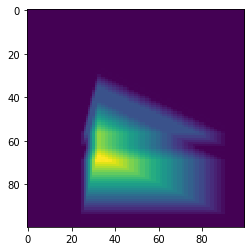

In [202]:
# This shouldn't need flipping/transposing because it is projection data
plt.imshow(raw_data[:,7,:])
thetas[9]*180/np.pi

In [203]:
# Load data objects into astra C layer
proj_geom = astra.create_proj_geom('parallel3d_vec',100,100,np.array(vectors))
projections_id = astra.data3d.create('-sino', proj_geom, raw_data)
# proj_geom = astra.create_proj_geom('parallel3d',1,1,100,100,np.array(thetas))
# projections_id = astra.data3d.create('-sino', proj_geom, np.transpose(raw_data,axes=[2,1,0]))
vol_geom = astra.creators.create_vol_geom(100, 100,
                                          100)
reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
alg_cfg = astra.astra_dict('SIRT3D_CUDA')
alg_cfg['ProjectionDataId'] = projections_id
alg_cfg['ReconstructionDataId'] = reconstruction_id
algorithm_id = astra.algorithm.create(alg_cfg)

In [204]:
# Run algorithm
astra.algorithm.run(algorithm_id,iterations=20)
reconstruction = astra.data3d.get(reconstruction_id)
np.shape(reconstruction)

(100, 100, 100)

This works if:
- P_rot is flipped and transposed
- The projection dataset is then transposed [1,0,2]
- r is just mrot.[0,0,1]
- ay becomes -ay in rotate bulk
- We then reverse column order and flip y

0.6908425957614598

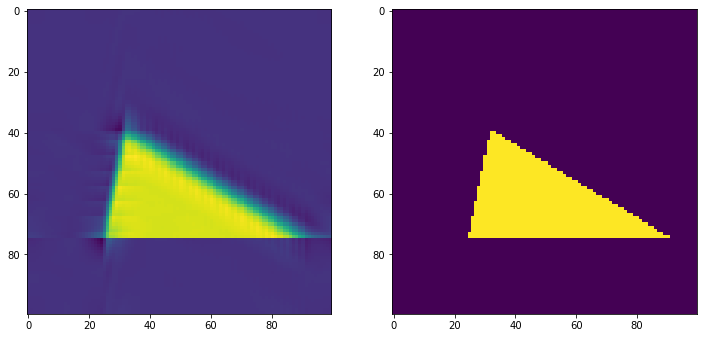

In [210]:
# This seems to work well for single axis datasets with raw data transpose [1,0,2]

# Swap columns back to match orientation of phantom
r = np.transpose(reconstruction,[2,1,0]) # Reverse column order
r = r[:,::-1,:] # Reverse the y data
r = r -  r.min() # normalise
r = r/r.max()

recon_vector = copy.deepcopy(r)

ax,ay,az = 0,0,0
a = multi_axis.rotate_bulk(recon_vector,ax,ay,az)
#multi_axis.plot_2d(X,Y,Z,a)

fig= plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(np.flipud(np.mean(a,axis=2).T))
ax2.imshow(np.flipud(np.mean(multi_axis.rotate_bulk(P,ax,ay,az),axis=2).T))

opt = optimize.minimize(phantom_error,1,args=(recon_vector,P2))
opt.fun

In [156]:
P2 = P -  P.min()
P2 = P2/P2.max()

In [152]:
def phantom_error(beta,recon,P):
    a = np.linalg.norm(recon*beta-P)
    b = np.linalg.norm(P)
    return a/b

In [157]:
opt = optimize.minimize(phantom_error,1,args=(recon_vector,P2))
opt.fun

0.8096159070351726

In [82]:
b = P -  P.min()
b = b/b.max()

In [90]:
np.max(recon_vector)

1.0

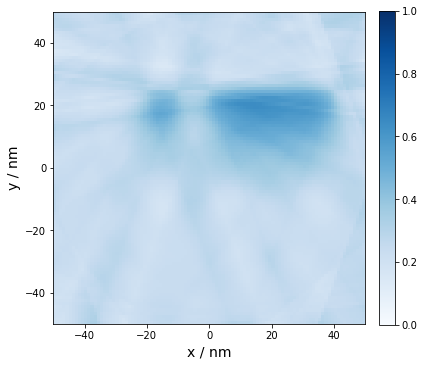

In [113]:
a = multi_axis.rotate_bulk(recon_vector,0,0,0)
multi_axis.plot_2d(X,Y,Z,a)

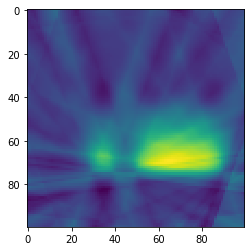

In [61]:
# Plot vector
plt.imshow(np.sum(recon_vector,axis=0))
#plt.colorbar()

a = multi_axis.rotate_bulk(recon_vector,0,0,0)
#multi_axis.plot_2d(X,Y,Z,a)
plt.imshow(np.sum(a,axis=2))
#plt.colorbar()

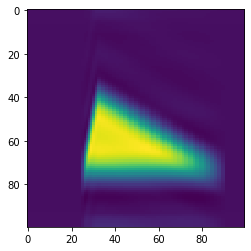

In [14]:
plt.imshow(np.mean(recon_normal,axis=0))

In [38]:
# Sum differences
np.sum(recon_vector-recon_normal)

-5.5531316e-05

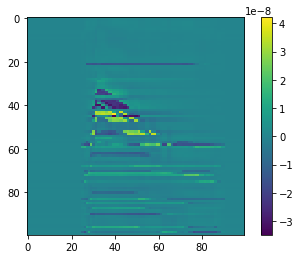

In [41]:
# Plot differences
a = recon_normal-recon_vector
plt.imshow(np.mean(a,axis=0))
plt.colorbar()